# Load packages and models

In [4]:
import os
import sys
from pathlib import Path

# Erkenne, ob wir auf Colab laufen
IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    from google.colab import drive, files

    drive.mount("/content/drive", force_remount=True)
    BASE_PATH = "/content"
    print("✓ Google Colab erkannt")
else:
    BASE_PATH = str(Path.home() / "ski_lift_data")
    os.makedirs(BASE_PATH, exist_ok=True)
    print(f"✓ Lokaler Modus: {BASE_PATH}")

✓ Lokaler Modus: /Users/dustin/ski_lift_data


In [5]:
# select file, if not running 'live' mode
if IS_COLAB:
    print("\nÜploadiere deine Datei (optional):")
    uploaded = files.upload()

✓ Imports geladen
✓ CPU aktiv
✓ Logging: /Users/dustin/dev/computer-vision-ski-lift-wait-time-estimator/ski_cam_logs/roi_counts_20260212_153450.csv
Bergfex mode...
✓ Webcam ID: 114
✓ Trying Feratel: https://webtv.feratel.com/webtv/?cam=5665
✓ Found stream URL: https://sts108.feratel.co.at/streams/stsstore105/1/05665_698de159-7e5cVid.mp4?dcsdesign=feratel4...
Stream: 1920x1080, Referenz: 2090x1164
ROI: (183, 463) bis (872, 835)


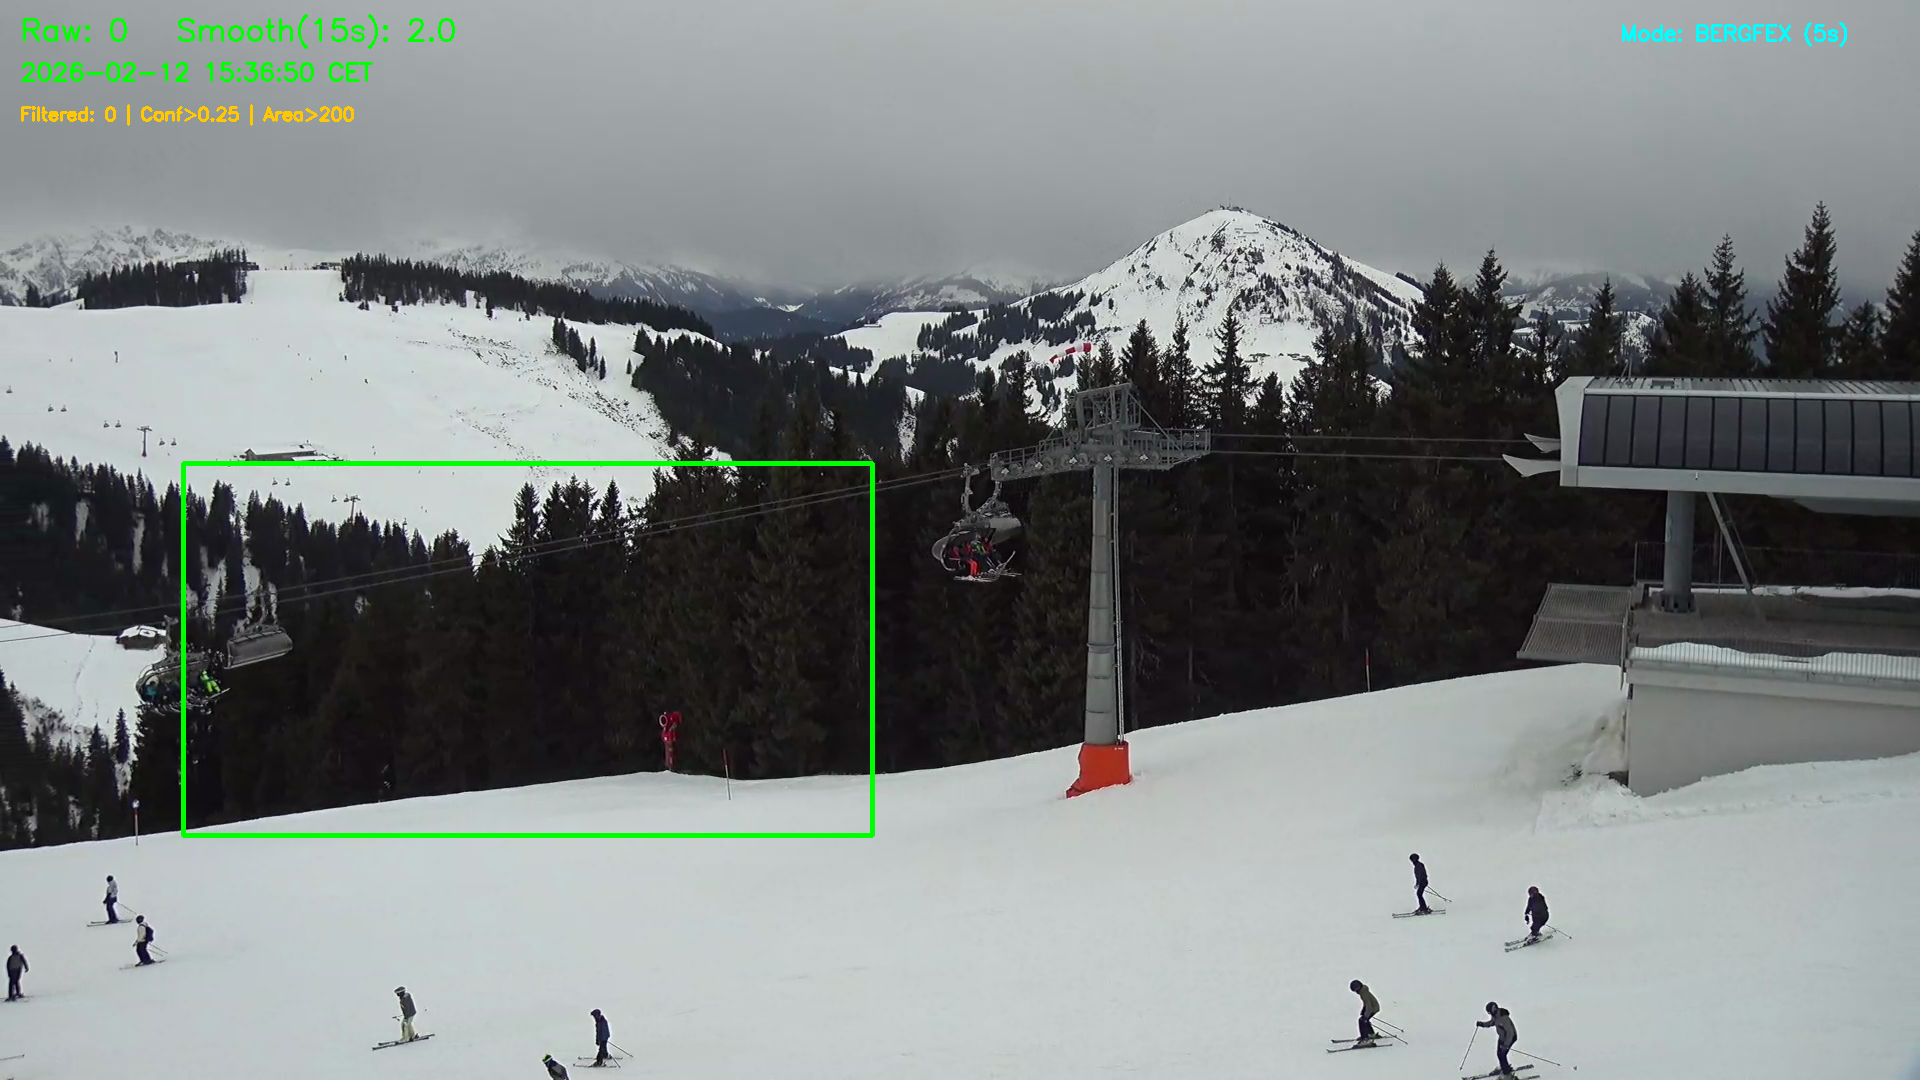


▶️ Start der Verarbeitung (max 120s)...

Frame 0: Gezählt=22, Gefiltert=5
Frame 0 | FPS:2.9 | raw=22, smooth=22.0
Frame 1 | FPS:2.6 | raw=22, smooth=22.0
Frame 2 | FPS:3.5 | raw=26, smooth=23.3
Frame 3 | FPS:4.5 | raw=22, smooth=23.0
Frame 4 | FPS:3.7 | raw=20, smooth=22.4
Frame 5 | FPS:2.2 | raw=20, smooth=22.0
Frame 6 | FPS:3.7 | raw=22, smooth=22.0
Frame 7 | FPS:4.3 | raw=23, smooth=22.1
Frame 8 | FPS:3.3 | raw=23, smooth=22.2
Frame 9 | FPS:4.5 | raw=21, smooth=22.1
Frame 10 | FPS:3.9 | raw=24, smooth=22.3
Frame 11 | FPS:3.9 | raw=27, smooth=22.7
Frame 12 | FPS:3.0 | raw=24, smooth=22.8
Frame 13 | FPS:3.1 | raw=24, smooth=22.9
Frame 14 | FPS:3.2 | raw=26, smooth=23.1
Frame 15 | FPS:3.3 | raw=26, smooth=23.2
Frame 16 | FPS:3.1 | raw=29, smooth=23.6
Frame 17 | FPS:3.9 | raw=26, smooth=23.7
Frame 18 | FPS:3.2 | raw=28, smooth=23.9
Frame 19 | FPS:4.7 | raw=24, smooth=23.9
Frame 20 | FPS:3.8 | raw=22, smooth=23.9
Frame 21 | FPS:4.2 | raw=24, smooth=23.9
Frame 22 | FPS:2.9 | raw=21, smoo

In [6]:
# ============================================================
# INSTALLS & IMPORTS
# ============================================================
# !pip install ultralytics yt-dlp streamlink -q

import cv2, time, subprocess, shlex, os, csv, datetime
import numpy as np
import pandas as pd
from ultralytics import YOLO
from IPython.display import display, clear_output, DisplayHandle
from PIL import Image
from zoneinfo import ZoneInfo
from collections import deque
import torch
import requests
from io import BytesIO
import sys

# Import config and utilities
sys.path.append(os.path.join(BASE_DIR, 'src'))
from config import *
from utils import extract_feratel_webtv_stream_url, extract_bergfex_stream_url, inside_roi

print("✓ Imports geladen")

# ============================================================
# MODEL & GPU/CPU
# ============================================================

model = YOLO(MODEL_PATH)

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    model.to("cuda")
    print("✓ GPU (CUDA) aktiv")
else:
    print("✓ CPU aktiv")

# ============================================================
# LOGGING
# ============================================================

TZ = ZoneInfo(TIMEZONE)
SESSION_START = datetime.datetime.now(TZ).strftime("%Y%m%d_%H%M%S")

LOG_PATH = os.path.join(BASE_DIR, LOG_DIR, f"roi_counts_{SESSION_START}.csv")
os.makedirs(os.path.join(BASE_DIR, LOG_DIR), exist_ok=True)

log_file = open(LOG_PATH, "w", newline="")
log_writer = csv.writer(log_file)
log_writer.writerow(["frame_idx", "epoch_time", "local_time", "raw_count", "smoothed_count", "filtered_out_count"])
log_file.flush()

history = deque()
print(f"✓ Logging: {LOG_PATH}")

# ============================================================
# SCREENSHOTS
# ============================================================

os.makedirs(os.path.join(BASE_DIR, SCREENSHOT_DIR), exist_ok=True)
last_screenshot_time = 0.0

# ============================================================
# VIDEO CAPTURE INITIALISIERUNG
# ============================================================

cap = None
bergfex_image_url = None
bergfex_is_video_stream = False
last_bergfex_fetch = 0

if MODE == "file":
    print(f"File mode: {INPUT_VIDEO}")
    input_video = os.path.join(BASE_DIR, INPUT_VIDEO)
    cap = cv2.VideoCapture(input_video)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

elif MODE == "live":
    print("Live mode: YouTube stream...")
    cmd = f'yt-dlp -f best -g "{YOUTUBE_URL}"'
    if COOKIES_PATH and os.path.exists(COOKIES_PATH):
        cmd = f'yt-dlp --cookies "{COOKIES_PATH}" -f best -g "{YOUTUBE_URL}"'
    
    proc = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = proc.communicate()
    stream_url = stdout.decode().strip().split("\n")[0]
    
    if not stream_url:
        raise RuntimeError("Could not resolve stream URL")
    
    cap = cv2.VideoCapture(stream_url)

elif MODE == "feratel":
    print("Feratel WebTV mode...")
    stream_url = extract_feratel_webtv_stream_url(FERATEL_URL, FERATEL_USER_AGENT, FERATEL_USE_STREAMLINK)
    cap = cv2.VideoCapture(stream_url)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

elif MODE == "bergfex":
    print("Bergfex mode...")
    bergfex_url_or_stream, bergfex_is_video_stream = extract_bergfex_stream_url(BERGFEX_URL)
    
    if bergfex_is_video_stream:
        if 'webtv.feratel.com' in bergfex_url_or_stream:
            stream_url = extract_feratel_webtv_stream_url(bergfex_url_or_stream, FERATEL_USER_AGENT, FERATEL_USE_STREAMLINK)
        else:
            stream_url = bergfex_url_or_stream
        
        cap = cv2.VideoCapture(stream_url)
        W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    else:
        bergfex_image_url = bergfex_url_or_stream
        response = requests.get(bergfex_image_url, timeout=10)
        img_array = np.frombuffer(response.content, dtype=np.uint8)
        frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        H, W = frame.shape[:2]
else:
    raise ValueError("MODE must be 'file', 'live', 'feratel', or 'bergfex'")

# ============================================================
# ROI SKALIERUNG
# ============================================================

if cap is not None:
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Stream: {W}x{H}, Referenz: {REF_WIDTH}x{REF_HEIGHT}")

scale_x = W / REF_WIDTH
scale_y = H / REF_HEIGHT

roi_x1 = int(BASE_ROI_X1 * scale_x)
roi_y1 = int(BASE_ROI_Y1 * scale_y)
roi_x2 = int(BASE_ROI_X2 * scale_x)
roi_y2 = int(BASE_ROI_Y2 * scale_y)

roi_polygon = [(roi_x1, roi_y1), (roi_x2, roi_y1), (roi_x2, roi_y2), (roi_x1, roi_y2)]
roi_np = np.array(roi_polygon, np.int32)

print(f"ROI: ({roi_x1}, {roi_y1}) bis ({roi_x2}, {roi_y2})")

# ============================================================
# HAUPTSCHLEIFE
# ============================================================

frame_idx = 0
display_handle = DisplayHandle()
display_handle.display("Warte auf erstes Frame...")
last_preview_time = time.time()
preview_fps = 0
start_time = time.time()

print(f"\n▶️ Start der Verarbeitung (max {MAX_SECONDS}s)...\n")

while True:
    # Exit Bedingungen
    elapsed = time.time() - start_time
    if frame_idx >= MAX_FRAMES:
        print(f"\n⚠️ MAX_FRAMES ({MAX_FRAMES}) erreicht. Stopp.")
        break
    if elapsed >= MAX_SECONDS:
        print(f"\n⏱️ MAX_SECONDS ({MAX_SECONDS}s) erreicht. Automatischer Stopp.")
        break

    # Frame abholen
    if MODE == "bergfex":
        if bergfex_is_video_stream:
            ret, frame = cap.read()
        else:
            now = time.time()
            if (now - last_bergfex_fetch) >= BERGFEX_POLL_INTERVAL:
                try:
                    response = requests.get(bergfex_image_url, timeout=10)
                    if response.status_code == 200:
                        img_array = np.frombuffer(response.content, dtype=np.uint8)
                        frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
                        last_bergfex_fetch = now
                        ret = frame is not None
                    else:
                        time.sleep(1)
                        continue
                except Exception as e:
                    print(f"⚠️ Fehler beim Bildabruf: {e}")
                    time.sleep(1)
                    continue
            else:
                time.sleep(0.1)
                continue
    else:
        ret, frame = cap.read()

    if not ret:
        if MODE in ["live", "feratel"] or (MODE == "bergfex" and bergfex_is_video_stream):
            time.sleep(0.1)
            continue
        else:
            break

    # Frame Skip
    if FRAME_SKIP > 0 and frame_idx % (FRAME_SKIP + 1) != 0:
        frame_idx += 1
        continue

    annotated = frame.copy()

    # ROI croppen und hochskalieren
    roi_crop = frame[roi_y1:roi_y2, roi_x1:roi_x2]
    roi_up = cv2.resize(roi_crop, (0, 0), fx=SCALE, fy=SCALE)

    # YOLO Segmentierung
    results = model.predict(roi_up, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD, verbose=False)
    masks = results[0].masks
    boxes = results[0].boxes

    ids_in_roi = []
    filtered_out = 0
    debug_info = []

    # Masken verarbeiten
    if masks is not None:
        for i, mask in enumerate(masks.data):
            if PERSON_CLASS_ONLY:
                cls_id = int(boxes.cls[i])
                if cls_id != 0:
                    filtered_out += 1
                    continue

            m = mask.cpu().numpy().astype(np.uint8)
            if m.sum() == 0:
                filtered_out += 1
                continue

            mask_full = cv2.resize(m, (roi_x2 - roi_x1, roi_y2 - roi_y1), interpolation=cv2.INTER_NEAREST)
            mask_region = mask_full.astype(bool)
            ys_resized, xs_resized = np.where(mask_full > 0)

            if len(xs_resized) == 0:
                filtered_out += 1
                continue

            mask_area = len(xs_resized)
            if mask_area < MIN_MASK_AREA:
                filtered_out += 1
                continue

            cx_roi = xs_resized.mean()
            cy_roi = ys_resized.mean()
            cx_full = int(cx_roi + roi_x1)
            cy_full = int(cy_roi + roi_y1)

            is_counted = inside_roi(cx_full, cy_full, roi_polygon)

            if is_counted:
                ids_in_roi.append(i)
                conf = float(boxes.conf[i])
                debug_info.append({"id": i, "conf": conf, "area": mask_area, "cx": cx_full, "cy": cy_full})

            # Maske zeichnen
            color = (0, 255, 0) if is_counted else (0, 150, 0)
            alpha = 0.45 if is_counted else 0.25

            roi_slice = annotated[roi_y1:roi_y2, roi_x1:roi_x2]
            overlay = roi_slice.copy()
            overlay[mask_region] = color
            roi_slice[mask_region] = cv2.addWeighted(roi_slice, 1 - alpha, overlay, alpha, 0)[mask_region]
            annotated[roi_y1:roi_y2, roi_x1:roi_x2] = roi_slice

            if DEBUG_MODE and is_counted:
                cv2.circle(annotated, (cx_full, cy_full), 6, (0, 0, 255), -1)
                cv2.circle(annotated, (cx_full, cy_full), 6, (255, 255, 255), 2)

    # Debug Print
    if DEBUG_MODE and frame_idx % DEBUG_PRINT_EVERY == 0 and debug_info:
        print(f"Frame {frame_idx}: Gezählt={len(ids_in_roi)}, Gefiltert={filtered_out}")

    # Logging + Glättung
    now_epoch = time.time()
    local_dt = datetime.datetime.fromtimestamp(now_epoch, TZ)
    local_str = local_dt.strftime("%Y-%m-%d %H:%M:%S %Z")

    raw_count = len(ids_in_roi)
    
    history.append((now_epoch, raw_count))
    while history and (now_epoch - history[0][0] > SMOOTH_WINDOW_SEC):
        history.popleft()

    smooth_count = sum(c for _, c in history) / len(history) if history else 0.0

    log_writer.writerow([frame_idx, now_epoch, local_str, raw_count, smooth_count, filtered_out])
    
    if frame_idx % 120 == 0:
        log_file.flush()

    # Overlays zeichnen
    cv2.polylines(annotated, [roi_np], True, (0, 255, 0), 3)
    cv2.putText(annotated, f"Raw: {raw_count}   Smooth({SMOOTH_WINDOW_SEC}s): {smooth_count:.1f}", 
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
    cv2.putText(annotated, local_str, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    if DEBUG_MODE:
        cv2.putText(annotated, f"Filtered: {filtered_out} | Conf>{CONF_THRESHOLD} | Area>{MIN_MASK_AREA}",
                    (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 200, 255), 2)

    mode_text = f"Mode: {MODE.upper()}"
    if MODE == "bergfex":
        mode_text += f" ({BERGFEX_POLL_INTERVAL}s)"
    cv2.putText(annotated, mode_text, (W - 300, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    # Screenshots
    if MODE in ["live", "feratel", "bergfex"] and raw_count >= SCREENSHOT_THRESHOLD and (now_epoch - last_screenshot_time) > SCREENSHOT_COOLDOWN:
        filename_time_str = local_dt.strftime("%Y%m%d_%H%M%S")
        screenshot_path = os.path.join(BASE_DIR, SCREENSHOT_DIR, f"screenshot_{filename_time_str}_count{raw_count}.jpg")
        cv2.imwrite(screenshot_path, annotated)
        last_screenshot_time = now_epoch

    # Live Preview
    if LIVE_PREVIEW and frame_idx % PREVIEW_EVERY == 0:
        now_preview = time.time()
        dt = now_preview - last_preview_time
        if dt > 0:
            preview_fps = 1.0 / dt
        last_preview_time = now_preview
        
        print(f"Frame {frame_idx} | FPS:{preview_fps:.1f} | raw={raw_count}, smooth={smooth_count:.1f}")
        rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        display_handle.update(Image.fromarray(rgb))

    frame_idx += 1

# ============================================================
# CLEANUP
# ============================================================

if cap is not None:
    cap.release()

log_file.flush()
log_file.close()

print("\n" + "=" * 60)
print(f"✅ Fertig! {frame_idx} Frames verarbeitet in {elapsed:.1f}s")
print(f"📊 Log: {LOG_PATH}")
print("=" * 60)
